<a href="https://colab.research.google.com/github/vackup/CovidArgentina/blob/master/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
today = date.today()

In [0]:
df = pd.read_json('https://pomber.github.io/covid19/timeseries.json')

In [0]:
df2 = pd.DataFrame(df['Argentina'].values.tolist())


In [0]:
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
df2 = df2.loc['2020-03-01' : today]

In [7]:
df2.shape


(52, 3)

In [8]:
df2.head(3)

,confirmed,deaths,recovered
date,,,
2020-03-01,0,0,0
2020-03-02,0,0,0
2020-03-03,1,0,0


In [9]:
df2.tail(3)

,confirmed,deaths,recovered
date,,,
2020-04-19,2839,132,709
2020-04-20,2941,136,737
2020-04-21,3031,147,840


In [10]:
df2.dtypes

confirmed    int64
deaths       int64
recovered    int64
dtype: object

In [11]:
df2.index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21'],
              dtype='datetime64[ns]', name='date', freq=None)

In [0]:
df2['Weekday Name'] = df2.index.day_name()

In [13]:
# Display a random sampling of 5 rows
df2.sample(5, random_state=0)

,confirmed,deaths,recovered,Weekday Name
date,,,,
2020-03-29,745,19,72,Sunday
2020-04-07,1628,56,338,Tuesday
2020-03-12,19,1,0,Thursday
2020-04-04,1451,43,279,Saturday
2020-03-03,1,0,0,Tuesday


In [0]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(25, 15)})

In [0]:
#cols_plot = ['confirmed', 'deaths', 'recovered']

#axes = df2[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
#for ax in axes:
#    ax.set_ylabel('Daily Totals')

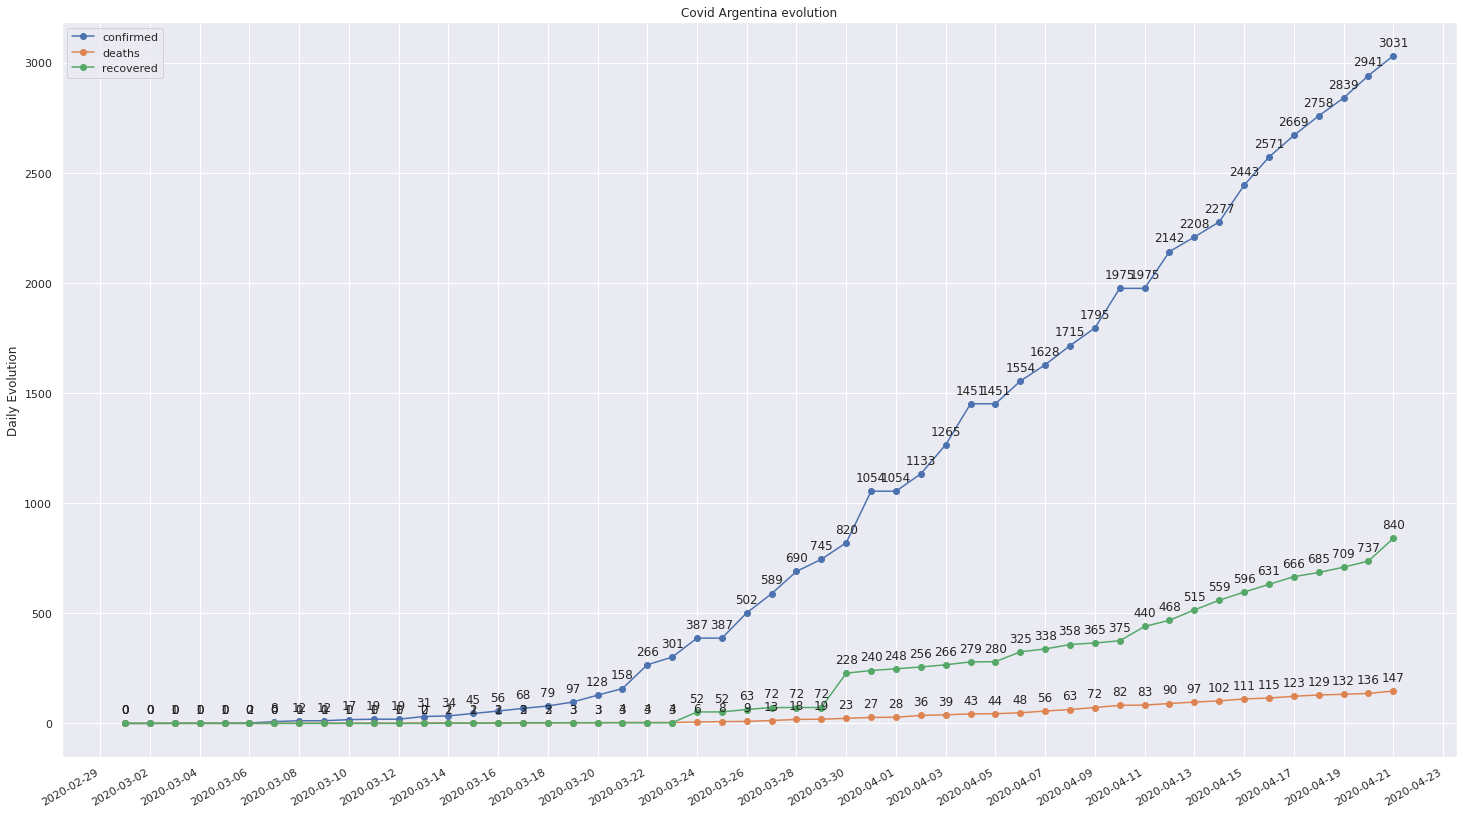

In [16]:
cols_plot = ['confirmed', 'deaths', 'recovered']

fig, ax = plt.subplots()

ax.plot(df2['confirmed'], marker='o', linestyle='-', label='confirmed')
ax.plot(df2['deaths'], marker='o', linestyle='-', label='deaths')
ax.plot(df2['recovered'], marker='o', linestyle='-', label='recovered')
#ax.plot(df2[cols_plot], marker='o', linestyle='-')

ax.set_ylabel('Daily Evolution')
ax.set_title('Covid Argentina evolution')

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

plt.legend(loc="upper left")
#plt.legend(cols_plot)

fig.autofmt_xdate()

for X, Y in zip(df2.index, df2['confirmed']):
    label = "{:.0f}".format(Y)

    ax.annotate(label, # this is the text
                 (X,Y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for X, Y in zip(df2.index, df2['deaths']):
    label = "{:.0f}".format(Y)

    ax.annotate(label, # this is the text
                 (X,Y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for X, Y in zip(df2.index, df2['recovered']):
    label = "{:.0f}".format(Y)

    ax.annotate(label, # this is the text
                 (X,Y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/Colab Notebooks/applemobilitytrends-2020-04-20.csv'
df_apple = pd.read_csv(path)

In [20]:
df_apple.head(5)

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,...,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
0,country/region,Albania,driving,100,95.30,101.43,97.20,103.55,112.67,104.83,94.39,94.07,93.51,92.94,102.13,102.38,101.41,94.62,89.12,90.17,90.21,97.71,102.50,108.92,92.82,91.48,93.99,96.72,102.46,103.29,107.83,87.99,94.18,94.62,99.70,139.30,123.90,129.41,102.24,88.09,...,43.79,24.99,24.61,30.93,24.69,24.95,24.65,24.50,26.31,20.39,19.29,22.62,21.61,21.98,23.07,23.94,19.49,21.78,23.66,25.11,25.02,25.20,24.11,20.54,22.54,26.40,26.03,26.43,26.70,26.32,25.47,24.89,32.64,31.43,30.67,30.00,29.26,22.94,24.55,31.51
1,country/region,Albania,walking,100,100.68,98.93,98.46,100.85,100.13,82.13,95.65,97.78,95.39,94.24,93.73,97.06,77.27,83.37,82.73,84.39,88.19,90.79,88.70,79.32,87.12,88.06,99.40,85.84,94.63,99.74,81.41,90.19,90.45,94.16,95.69,109.21,108.40,84.52,96.63,87.38,...,37.87,31.43,37.78,37.44,35.95,30.87,33.56,36.84,32.62,27.12,22.64,25.93,25.88,25.42,23.03,28.27,24.69,20.26,22.90,25.93,23.50,26.65,27.76,24.90,23.92,31.13,25.80,29.81,28.96,27.29,27.63,29.59,35.52,38.08,35.48,39.15,34.58,27.76,27.93,36.72
2,country/region,Argentina,driving,100,97.07,102.45,111.21,118.45,124.01,95.44,95.13,95.42,97.66,99.42,113.34,118.23,91.31,93.37,91.12,92.35,96.74,111.24,123.96,89.01,91.66,89.18,94.49,95.98,111.12,121.53,89.23,96.42,96.97,101.68,104.90,122.91,127.62,88.20,92.28,98.15,...,86.67,98.75,84.77,47.70,53.57,45.44,43.21,43.90,16.77,12.54,8.74,10.08,10.76,14.86,14.58,15.45,13.34,9.92,14.59,12.65,15.79,16.48,17.15,15.13,11.53,17.24,18.55,19.95,19.80,16.80,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67
3,country/region,Argentina,walking,100,95.11,101.37,112.67,116.72,114.14,84.54,101.37,106.12,104.91,102.56,104.88,98.83,73.64,94.27,93.86,92.20,96.00,98.99,97.42,67.21,95.18,96.25,100.39,99.10,105.00,106.45,73.12,104.20,105.87,111.47,113.20,128.75,103.47,69.12,93.42,111.49,...,106.85,104.31,70.31,43.64,51.55,35.57,31.96,29.97,11.75,9.11,6.96,8.36,8.05,10.92,10.53,11.30,10.73,7.77,11.37,9.79,11.78,11.23,12.44,10.97,9.12,11.85,13.49,15.51,14.65,13.58,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44
4,country/region,Australia,driving,100,102.98,104.21,108.63,109.08,89.00,99.35,103.53,106.80,107.40,115.65,109.66,88.59,85.18,95.91,99.40,99.92,103.04,103.73,85.73,93.39,95.83,98.63,102.40,107.46,106.55,86.33,98.78,100.08,103.28,106.19,116.62,115.36,93.51,98.27,101.79,105.38,...,102.79,98.75,78.16,81.59,80.52,78.87,79.24,83.55,78.17,60.74,66.41,62.49,60.19,57.96,59.90,48.25,36.69,51.18,51.92,52.04,51.54,54.23,41.58,33.34,51.75,53.17,55.01,59.24,33.19,36.00,26.95,31.72,53.14,55.91,56.56,58.77,47.51,36.90,53.34,56.93


In [0]:
df_apple_argentina = df_apple[df_apple.region.eq("Argentina")]

In [32]:
df_apple_argentina.head()

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,...,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
2,country/region,Argentina,driving,100,97.07,102.45,111.21,118.45,124.01,95.44,95.13,95.42,97.66,99.42,113.34,118.23,91.31,93.37,91.12,92.35,96.74,111.24,123.96,89.01,91.66,89.18,94.49,95.98,111.12,121.53,89.23,96.42,96.97,101.68,104.9,122.91,127.62,88.20,92.28,98.15,...,86.67,98.75,84.77,47.70,53.57,45.44,43.21,43.90,16.77,12.54,8.74,10.08,10.76,14.86,14.58,15.45,13.34,9.92,14.59,12.65,15.79,16.48,17.15,15.13,11.53,17.24,18.55,19.95,19.80,16.80,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67
3,country/region,Argentina,walking,100,95.11,101.37,112.67,116.72,114.14,84.54,101.37,106.12,104.91,102.56,104.88,98.83,73.64,94.27,93.86,92.20,96.00,98.99,97.42,67.21,95.18,96.25,100.39,99.10,105.00,106.45,73.12,104.20,105.87,111.47,113.2,128.75,103.47,69.12,93.42,111.49,...,106.85,104.31,70.31,43.64,51.55,35.57,31.96,29.97,11.75,9.11,6.96,8.36,8.05,10.92,10.53,11.30,10.73,7.77,11.37,9.79,11.78,11.23,12.44,10.97,9.12,11.85,13.49,15.51,14.65,13.58,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44


In [33]:
df_apple_argentina.drop(columns=['geo_type', 'region'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [36]:
df_apple_argentina.head()

,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,...,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
2,driving,100,97.07,102.45,111.21,118.45,124.01,95.44,95.13,95.42,97.66,99.42,113.34,118.23,91.31,93.37,91.12,92.35,96.74,111.24,123.96,89.01,91.66,89.18,94.49,95.98,111.12,121.53,89.23,96.42,96.97,101.68,104.9,122.91,127.62,88.20,92.28,98.15,98.96,104.71,...,86.67,98.75,84.77,47.70,53.57,45.44,43.21,43.90,16.77,12.54,8.74,10.08,10.76,14.86,14.58,15.45,13.34,9.92,14.59,12.65,15.79,16.48,17.15,15.13,11.53,17.24,18.55,19.95,19.80,16.80,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67
3,walking,100,95.11,101.37,112.67,116.72,114.14,84.54,101.37,106.12,104.91,102.56,104.88,98.83,73.64,94.27,93.86,92.20,96.00,98.99,97.42,67.21,95.18,96.25,100.39,99.10,105.00,106.45,73.12,104.20,105.87,111.47,113.2,128.75,103.47,69.12,93.42,111.49,107.02,111.36,...,106.85,104.31,70.31,43.64,51.55,35.57,31.96,29.97,11.75,9.11,6.96,8.36,8.05,10.92,10.53,11.30,10.73,7.77,11.37,9.79,11.78,11.23,12.44,10.97,9.12,11.85,13.49,15.51,14.65,13.58,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44


In [0]:
df_apple_argentina = df_apple_argentina.set_index('transportation_type')

In [0]:
df_apple_argentina_t = df_apple_argentina.transpose()

In [41]:
df_apple_argentina_t.head()

transportation_type,driving,walking
2020-01-13,100.00,100.00
2020-01-14,97.07,95.11
2020-01-15,102.45,101.37
2020-01-16,111.21,112.67
2020-01-17,118.45,116.72


In [42]:
df_apple_argentina_t.dtypes

transportation_type
driving    float64
walking    float64
dtype: object

In [43]:
type(df_apple_argentina_t.index)

pandas.core.indexes.base.Index

In [0]:
# Converting the index as date
df_apple_argentina_t.index = pd.to_datetime(df_apple_argentina_t.index)

In [45]:
type(df_apple_argentina_t.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [47]:
df_apple_argentina_t.head()

transportation_type,driving,walking
2020-01-13,100.00,100.00
2020-01-14,97.07,95.11
2020-01-15,102.45,101.37
2020-01-16,111.21,112.67
2020-01-17,118.45,116.72


In [0]:
df_apple_argentina_t.index.rename('date', inplace=True)

In [56]:
df_apple_argentina_t.head()

transportation_type,driving,walking
date,,
2020-01-13,100.00,100.00
2020-01-14,97.07,95.11
2020-01-15,102.45,101.37
2020-01-16,111.21,112.67
2020-01-17,118.45,116.72


In [0]:
df_covid_apple = df2.join(df_apple_argentina_t)

In [62]:
df_covid_apple.head(5)

,confirmed,deaths,recovered,Weekday Name,driving,walking
date,,,,,,
2020-03-01,0,0,0,Sunday,81.13,68.50
2020-03-02,0,0,0,Monday,86.76,101.01
2020-03-03,1,0,0,Tuesday,88.90,104.39
2020-03-04,1,0,0,Wednesday,92.74,108.23
2020-03-05,1,0,0,Thursday,97.45,113.92


In [60]:
df_covid_apple.tail(5)

,confirmed,deaths,recovered,Weekday Name,driving,walking
date,,,,,,
2020-04-17,2669,123,666,Friday,27.17,18.80
2020-04-18,2758,129,685,Saturday,23.19,17.03
2020-04-19,2839,132,709,Sunday,14.54,10.59
2020-04-20,2941,136,737,Monday,26.67,18.44
2020-04-21,3031,147,840,Tuesday,NaN,NaN


In [0]:
df_covid_apple['total_request'] = df_covid_apple['driving'] + df_covid_apple['walking'] 

In [66]:
df_covid_apple.head()

,confirmed,deaths,recovered,Weekday Name,driving,walking,total_request
date,,,,,,,
2020-03-01,0,0,0,Sunday,81.13,68.50,149.63
2020-03-02,0,0,0,Monday,86.76,101.01,187.77
2020-03-03,1,0,0,Tuesday,88.90,104.39,193.29
2020-03-04,1,0,0,Wednesday,92.74,108.23,200.97
2020-03-05,1,0,0,Thursday,97.45,113.92,211.37


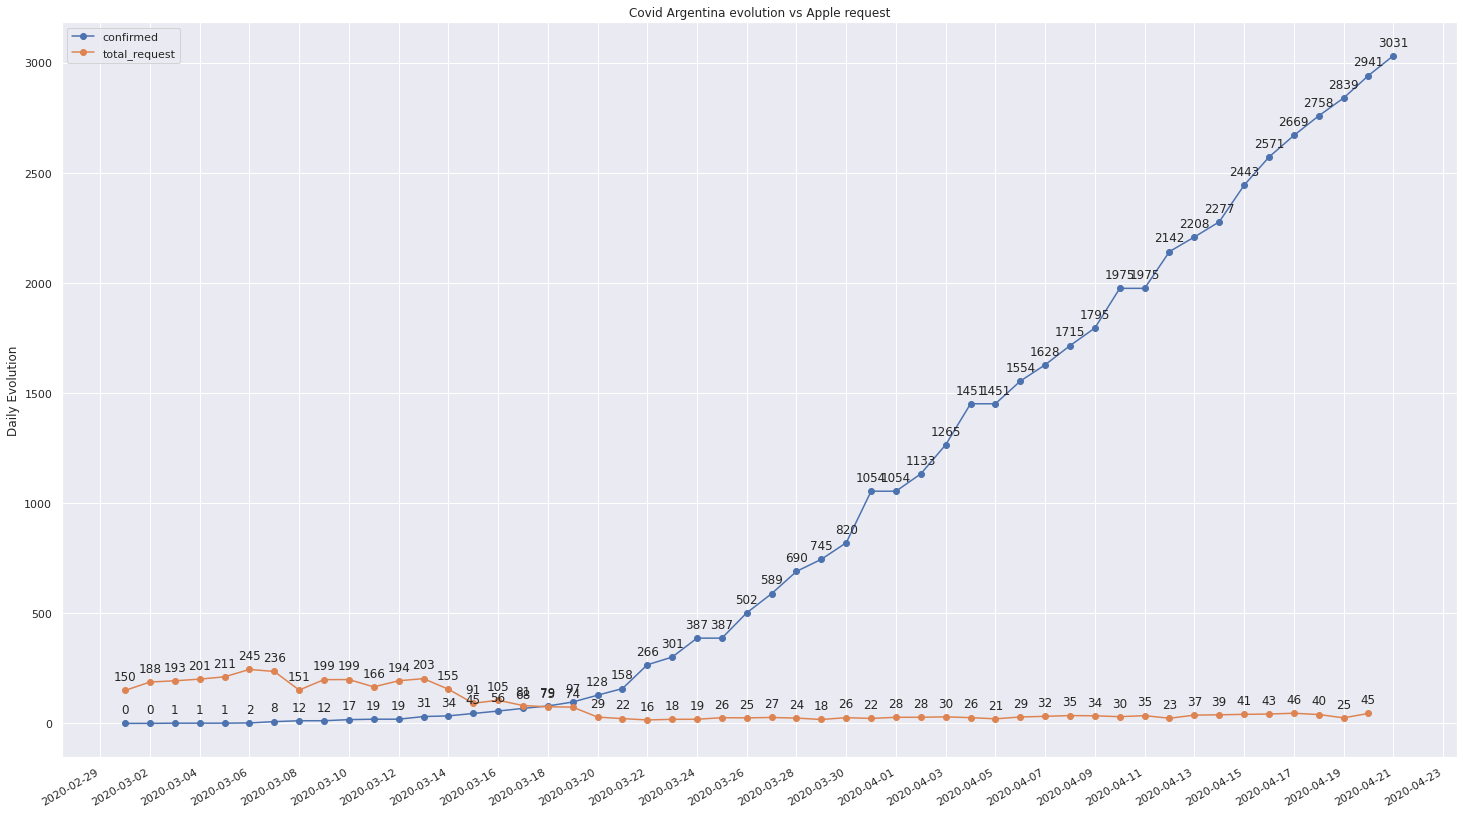

In [69]:
fig, ax = plt.subplots()

ax.plot(df_covid_apple['confirmed'], marker='o', linestyle='-', label='confirmed')
ax.plot(df_covid_apple['total_request'], marker='o', linestyle='-', label='total_request')

ax.set_ylabel('Daily Evolution')
ax.set_title('Covid Argentina evolution vs Apple request')

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

plt.legend(loc="upper left")

fig.autofmt_xdate()

for X, Y in zip(df_covid_apple.index, df_covid_apple['confirmed']):
    label = "{:.0f}".format(Y)

    ax.annotate(label, # this is the text
                 (X,Y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for X, Y in zip(df_covid_apple.index, df_covid_apple['total_request']):
    label = "{:.0f}".format(Y)

    ax.annotate(label, # this is the text
                 (X,Y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center